<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/splprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline
from numpy import arange, cos, linspace, pi, sin, random
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# make ascending spiral in 3-space
t=linspace(0,1.75*2*pi,100)

x = sin(t)
y = cos(t)
z = t


# spline parameters
s=.00001 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x,y,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,400),tck)


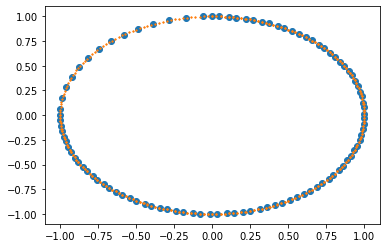

In [35]:
import matplotlib.pyplot as plt
ascatter = plt.scatter(x,y)
ascatter = plt.scatter(xnew,ynew,s=1)
plt.gca().add_artist(ascatter)


In [27]:
print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])

(23,)
(19,)
(19,)
3


torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


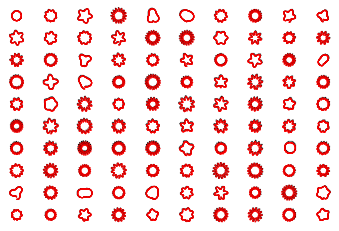

In [28]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            pred = model(sample).view(1000,3)
            print('pred', pred.shape)
            predres = numpoints
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
            
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)


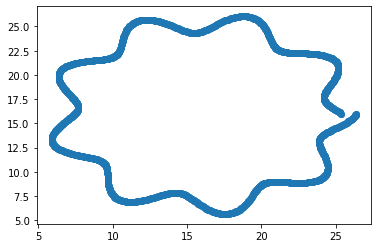

In [53]:
dataset[1][1].shape
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
ascatter = plt.scatter(x,y)
#ascatter = plt.scatter(xnew,ynew,s=1)
plt.gca().add_artist(ascatter)


In [71]:
t=np.linspace(0,1.75*2*pi,1000)
z = t

print(x.shape,y.shape,z.shape)
print(type(x),type(y),type(z))
# spline parameters
s=10 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=40)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


(35,)
(31,)
(31,)
3


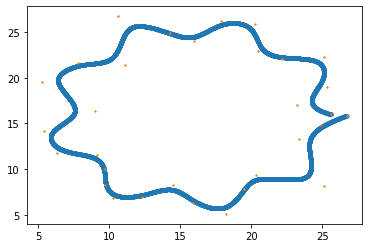

In [73]:
print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])
ascatter = plt.scatter(xnew,ynew,s=10)
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)


In [51]:

t=linspace(0,1.75*2*pi,100)

x = sin(t)
y = cos(t)
z = t

print(x.shape,y.shape,z.shape)
print(type(x))

# spline parameters
s=.00001 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x,y,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,400),tck)


(100,) (100,) (100,)
<class 'numpy.ndarray'>


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(35,)
(31,)
(31,)
3


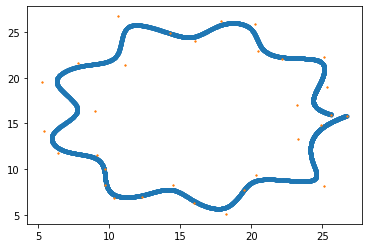

In [92]:
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
t=np.linspace(0,1,1000)
z = t

print(x.shape,y.shape,z.shape)
print(type(x),type(y),type(z))
# spline parameters
s=10 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=40)

# evaluate spline, including interpolated points
tck[0] = np.linspace(0,1,35)
tck[0][:4]=0
tck[0][-4:]=1
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])
ascatter = plt.scatter(xnew,ynew,s=10)
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)


In [80]:
print(tck[0])

[0.         0.         0.         0.         0.06101399 0.09211472
 0.12629629 0.15318152 0.18726561 0.21779284 0.25089913 0.27877351
 0.31230845 0.37387004 0.40548836 0.43688689 0.49713449 0.53190313
 0.56235615 0.59586502 0.62223987 0.64050546 0.65713298 0.68893015
 0.7190096  0.74879055 0.78168617 0.81553616 0.84207095 0.87541347
 0.93986843 1.         1.         1.         1.        ]


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(11,)
(7,)
(7,)
3


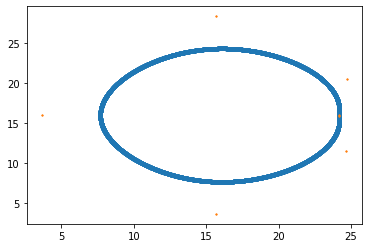

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(35,)
(31,)
(31,)
3


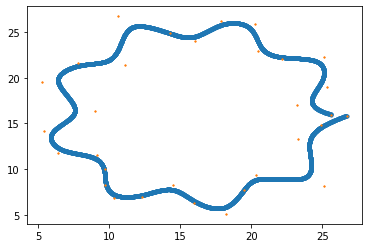

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(31,)
(27,)
(27,)
3


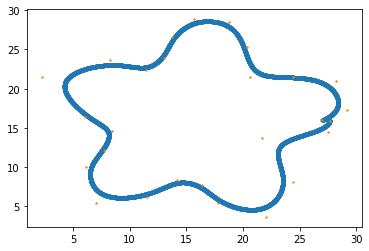

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(138,)
(134,)
(134,)
3


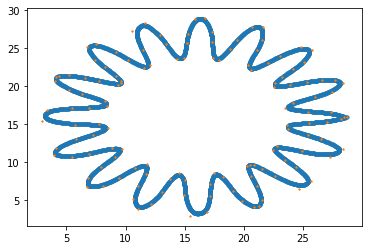

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(19,)
(15,)
(15,)
3


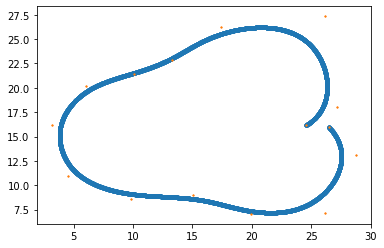

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(14,)
(10,)
(10,)
3


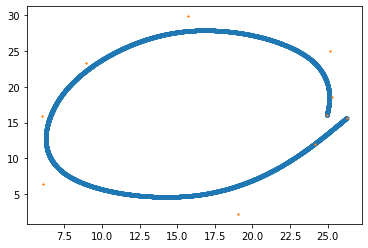

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(52,)
(48,)
(48,)
3


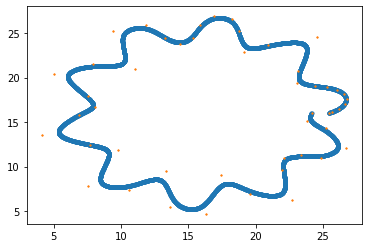

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(120,)
(116,)
(116,)
3


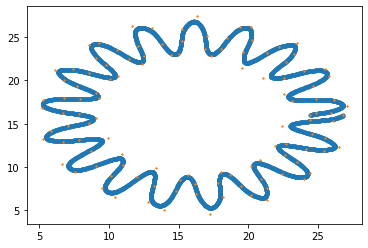

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(26,)
(22,)
(22,)
3


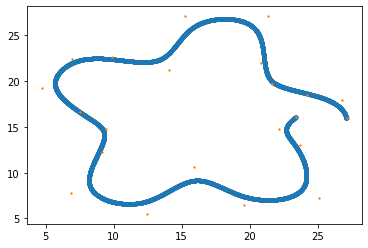

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(21,)
(17,)
(17,)
3


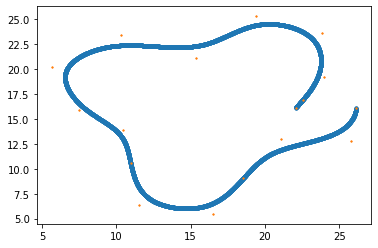

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(35,)
(31,)
(31,)
3


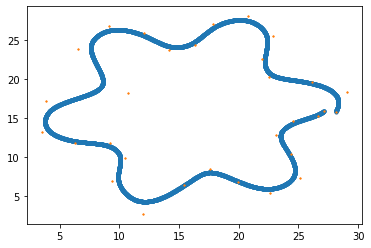

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(30,)
(26,)
(26,)
3


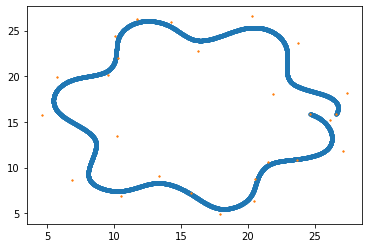

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(52,)
(48,)
(48,)
3


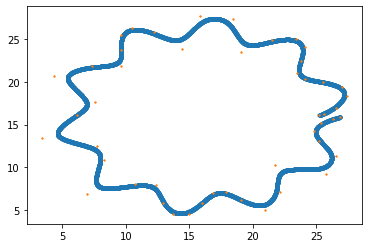

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(40,)
(36,)
(36,)
3


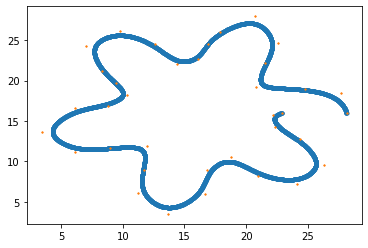

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(133,)
(129,)
(129,)
3


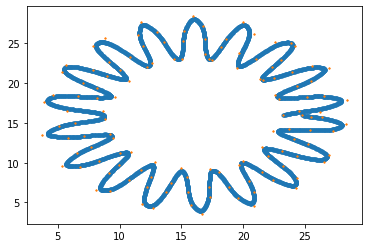

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(134,)
(130,)
(130,)
3


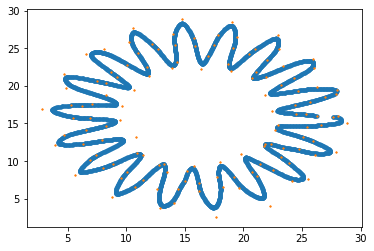

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(29,)
(25,)
(25,)
3


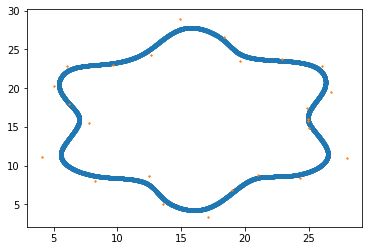

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(53,)
(49,)
(49,)
3


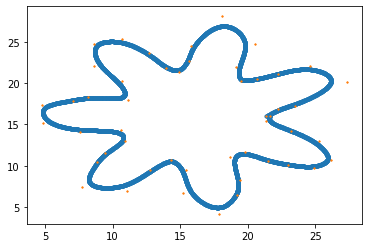

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(58,)
(54,)
(54,)
3


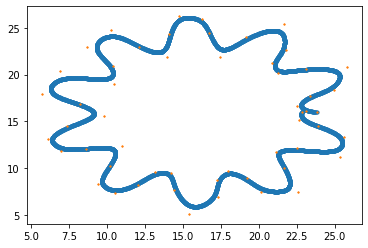

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(76,)
(72,)
(72,)
3


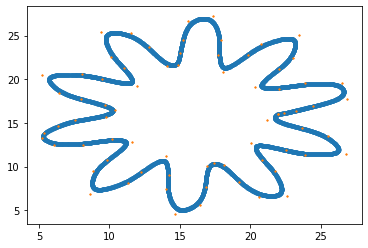

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(65,)
(61,)
(61,)
3


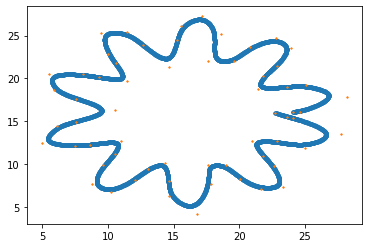

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(74,)
(70,)
(70,)
3


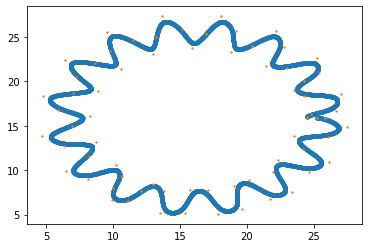

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(20,)
(16,)
(16,)
3


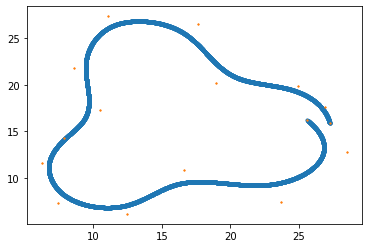

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(59,)
(55,)
(55,)
3


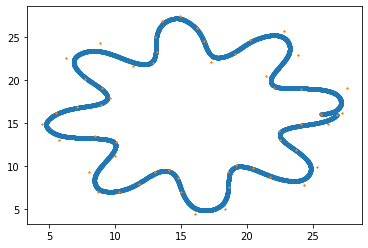

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(52,)
(48,)
(48,)
3


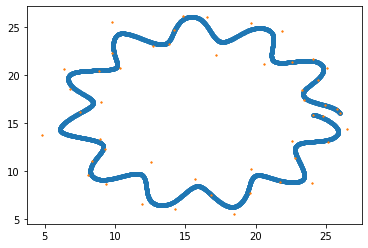

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(31,)
(27,)
(27,)
3


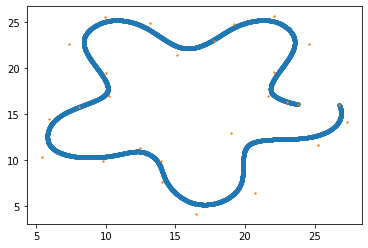

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(72,)
(68,)
(68,)
3


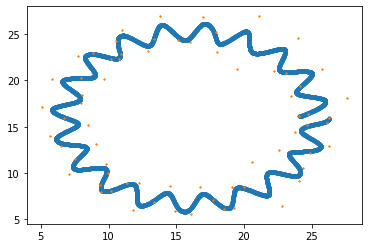

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(33,)
(29,)
(29,)
3


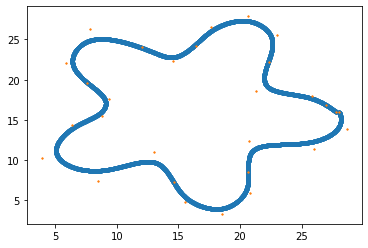

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(122,)
(118,)
(118,)
3


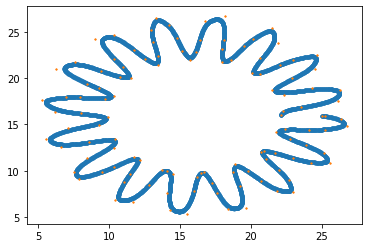

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(13,)
(9,)
(9,)
3


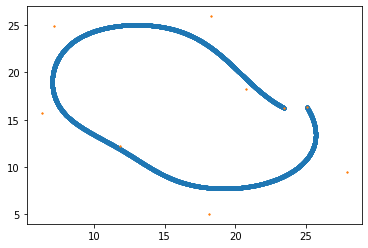

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(77,)
(73,)
(73,)
3


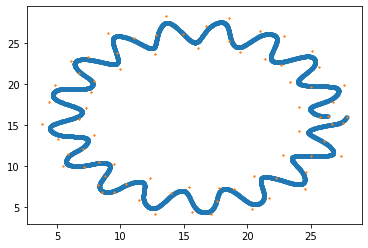

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(28,)
(24,)
(24,)
3


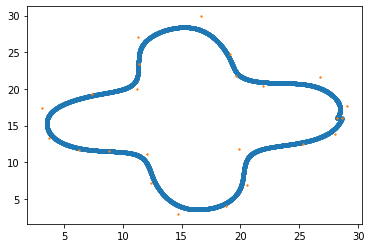

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(18,)
(14,)
(14,)
3


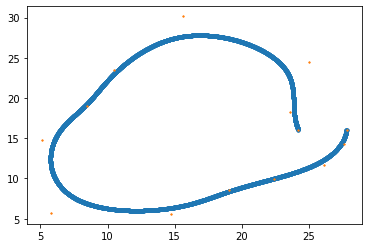

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(109,)
(105,)
(105,)
3


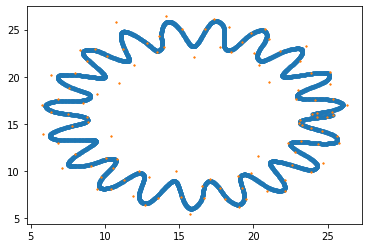

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(139,)
(135,)
(135,)
3


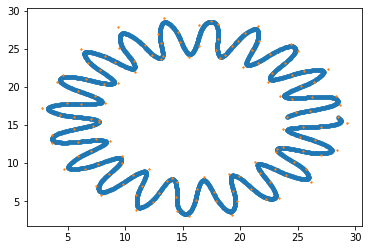

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(82,)
(78,)
(78,)
3


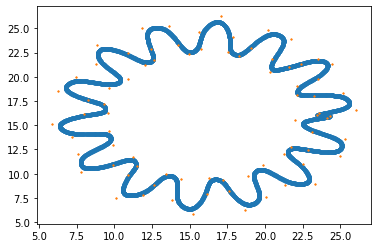

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(35,)
(31,)
(31,)
3


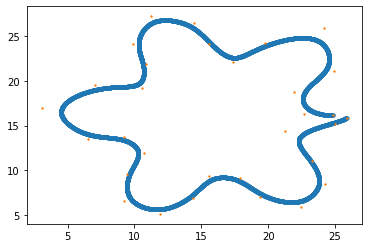

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(67,)
(63,)
(63,)
3


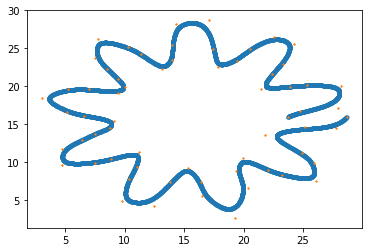

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(47,)
(43,)
(43,)
3


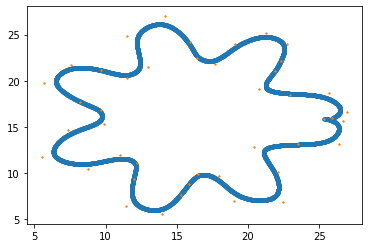

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(106,)
(102,)
(102,)
3


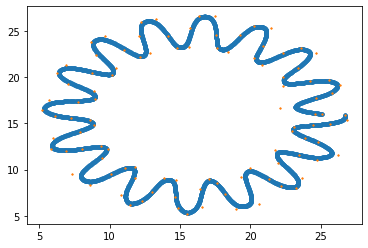

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(42,)
(38,)
(38,)
3


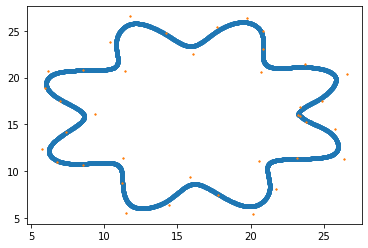

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(22,)
(18,)
(18,)
3


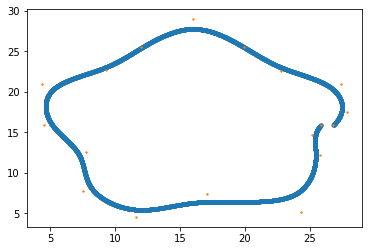

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(84,)
(80,)
(80,)
3


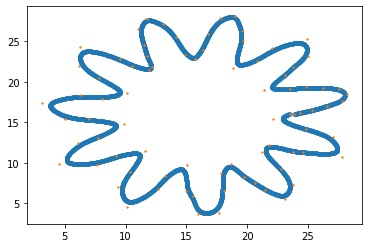

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(32,)
(28,)
(28,)
3


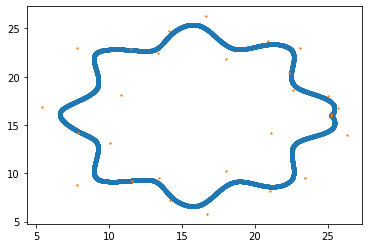

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(90,)
(86,)
(86,)
3


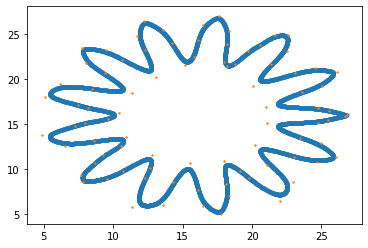

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(61,)
(57,)
(57,)
3


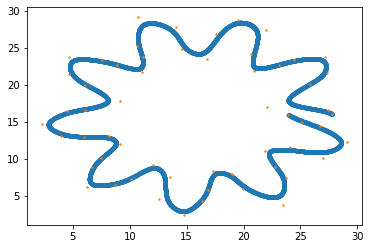

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(43,)
(39,)
(39,)
3


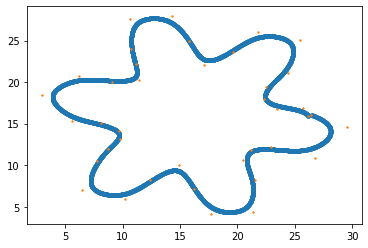

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(102,)
(98,)
(98,)
3


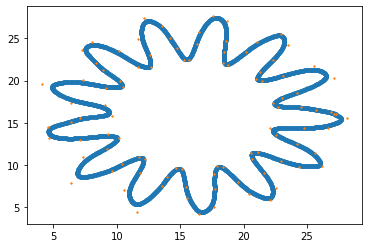

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(22,)
(18,)
(18,)
3


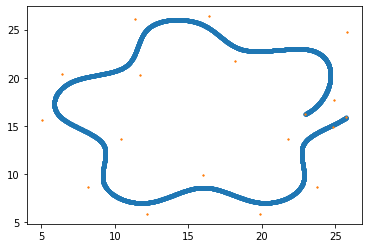

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(54,)
(50,)
(50,)
3


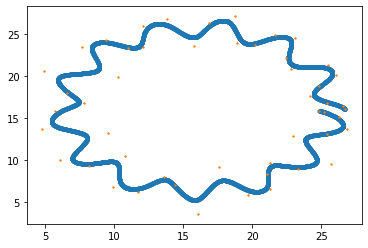

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(144,)
(140,)
(140,)
3


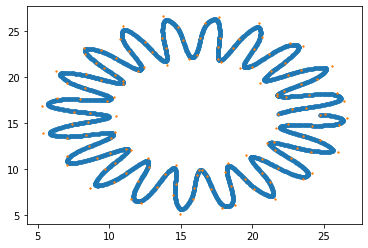

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(48,)
(44,)
(44,)
3


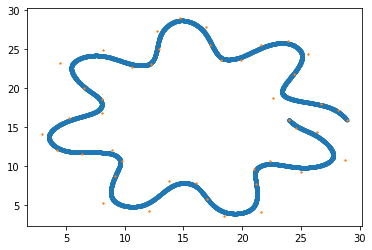

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(94,)
(90,)
(90,)
3


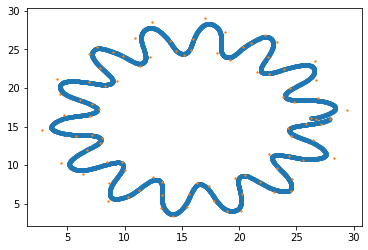

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(73,)
(69,)
(69,)
3


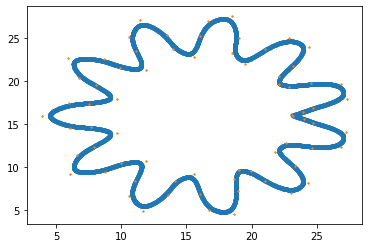

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(42,)
(38,)
(38,)
3


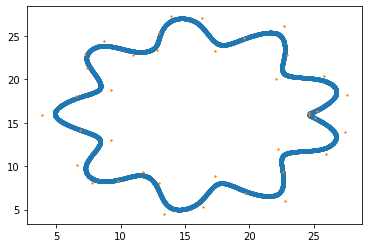

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(37,)
(33,)
(33,)
3


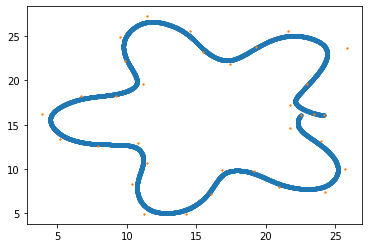

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(68,)
(64,)
(64,)
3


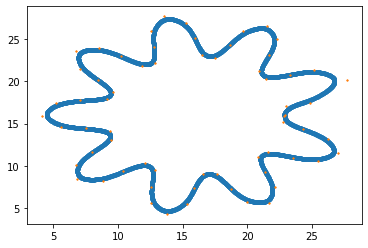

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(68,)
(64,)
(64,)
3


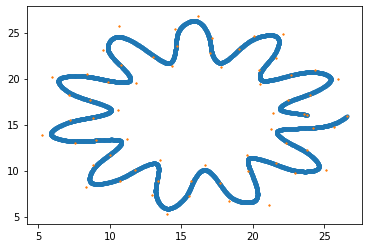

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(50,)
(46,)
(46,)
3


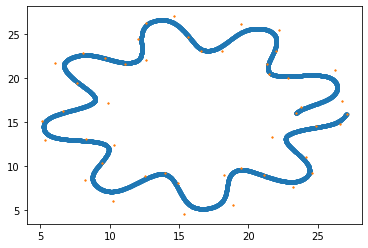

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(31,)
(27,)
(27,)
3


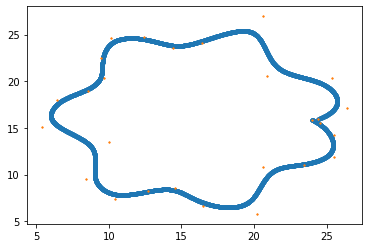

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(96,)
(92,)
(92,)
3


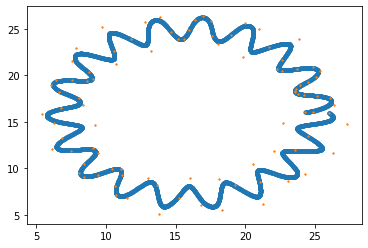

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(77,)
(73,)
(73,)
3


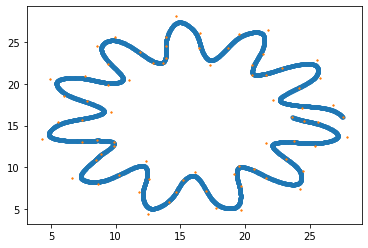

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(160,)
(156,)
(156,)
3


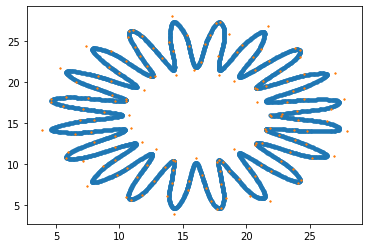

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(127,)
(123,)
(123,)
3


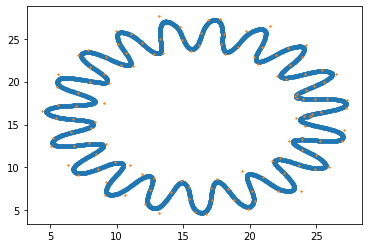

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(129,)
(125,)
(125,)
3


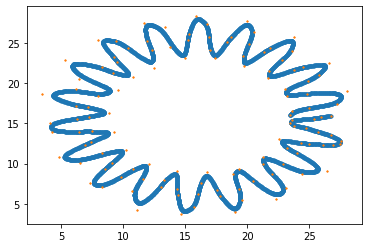

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(22,)
(18,)
(18,)
3


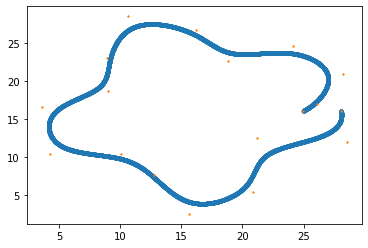

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(71,)
(67,)
(67,)
3


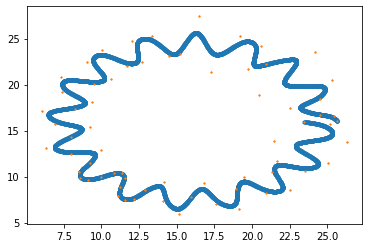

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(76,)
(72,)
(72,)
3


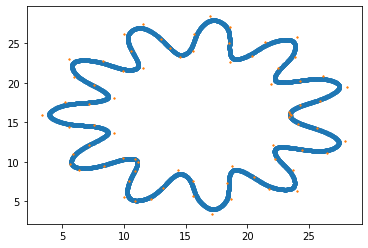

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(12,)
(8,)
(8,)
3


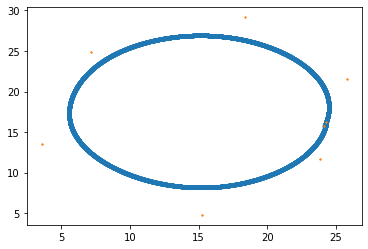

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(59,)
(55,)
(55,)
3


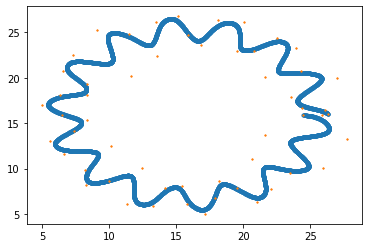

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(56,)
(52,)
(52,)
3


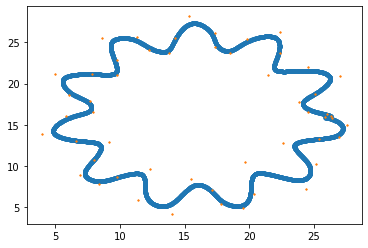

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(104,)
(100,)
(100,)
3


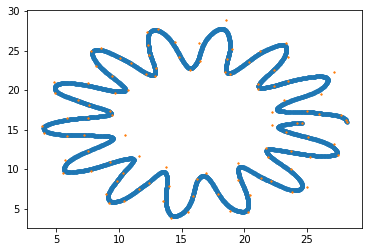

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(110,)
(106,)
(106,)
3


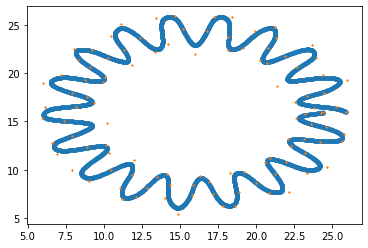

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(76,)
(72,)
(72,)
3


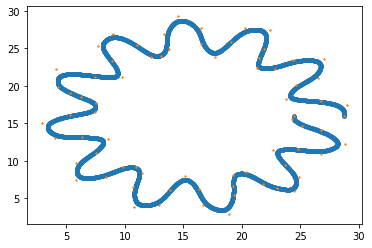

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(70,)
(66,)
(66,)
3


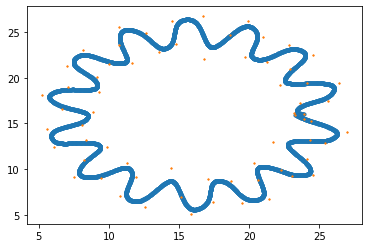

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(56,)
(52,)
(52,)
3


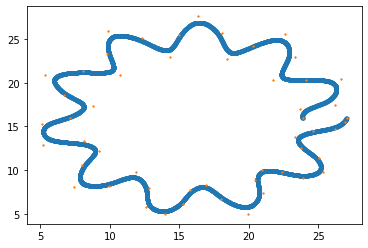

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(122,)
(118,)
(118,)
3


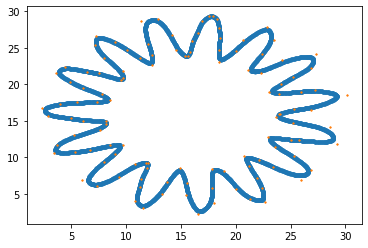

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(122,)
(118,)
(118,)
3


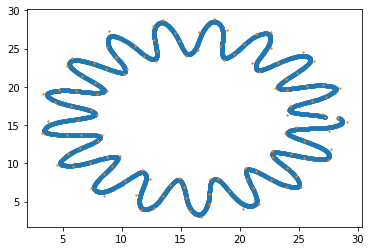

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(56,)
(52,)
(52,)
3


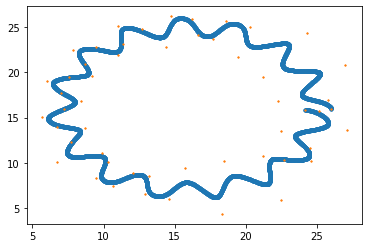

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(78,)
(74,)
(74,)
3


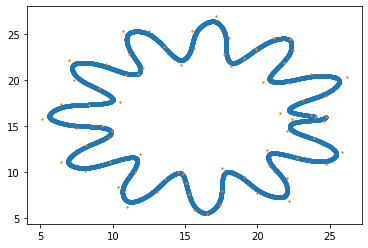

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(19,)
(15,)
(15,)
3


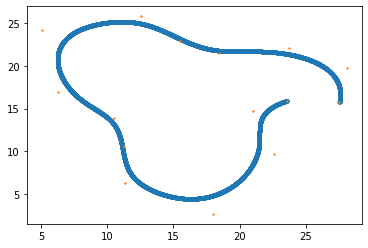

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(91,)
(87,)
(87,)
3


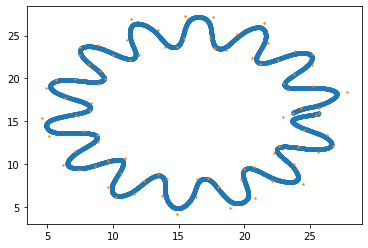

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(14,)
(10,)
(10,)
3


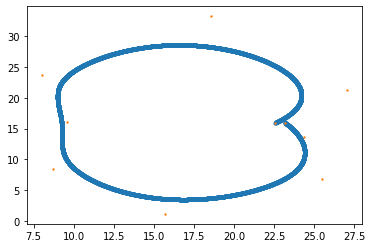

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(88,)
(84,)
(84,)
3


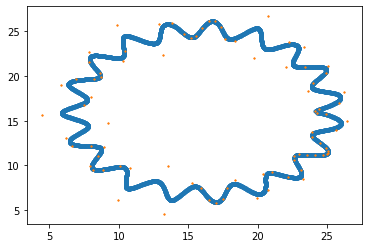

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(16,)
(12,)
(12,)
3


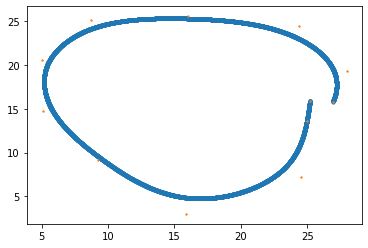

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(32,)
(28,)
(28,)
3


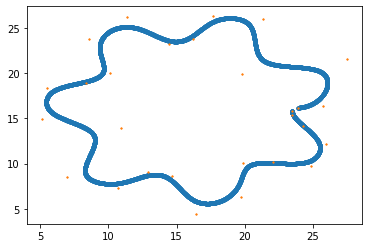

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(40,)
(36,)
(36,)
3


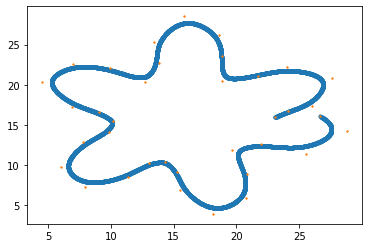

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(74,)
(70,)
(70,)
3


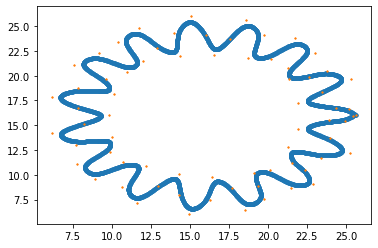

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(136,)
(132,)
(132,)
3


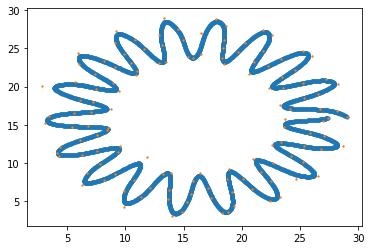

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(24,)
(20,)
(20,)
3


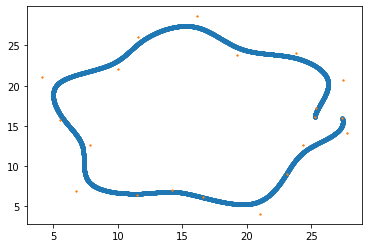

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(36,)
(32,)
(32,)
3


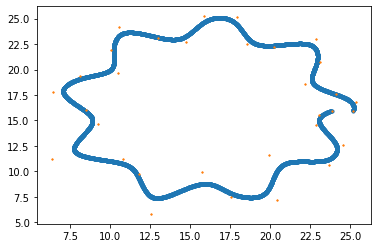

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(85,)
(81,)
(81,)
3


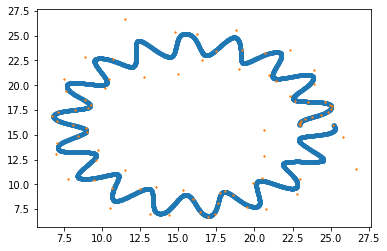

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(30,)
(26,)
(26,)
3


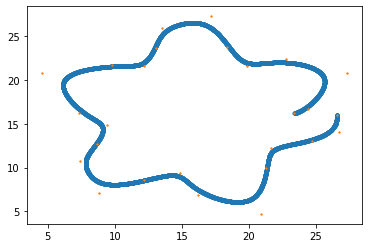

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(93,)
(89,)
(89,)
3


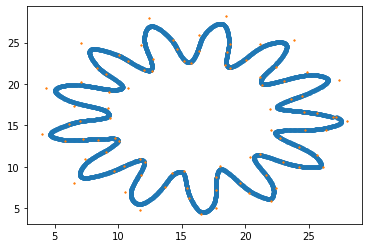

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(21,)
(17,)
(17,)
3


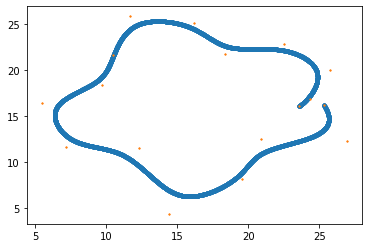

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(33,)
(29,)
(29,)
3


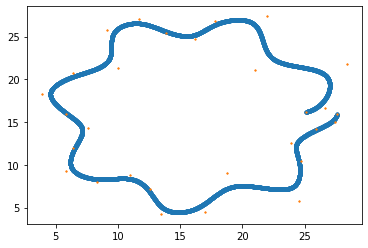

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(124,)
(120,)
(120,)
3


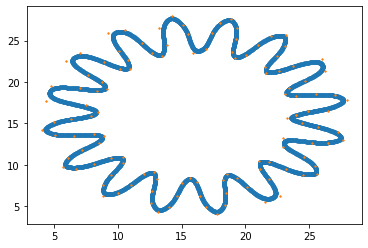

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(92,)
(88,)
(88,)
3


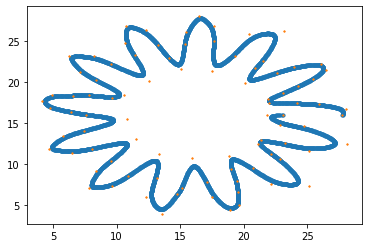

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(96,)
(92,)
(92,)
3


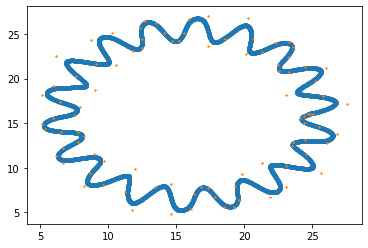

torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(23,)
(19,)
(19,)
3


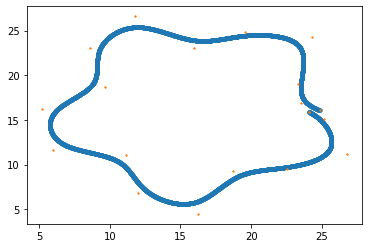

In [101]:
for xin,yin in dataset:
  x = yin[:,0]
  y = yin[:,1]
  t = np.linspace(0,1,1000)
  z = t

  print(x.shape,y.shape,z.shape)
  print(type(x),type(y),type(z))
  # spline parameters
  s=10 # smoothness parameter
  k=3 # spline order
  nest=-1 # estimate of number of knots needed (-1 = maximal)

  # find the knot points
  tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=nest)

  # evaluate spline, including interpolated points
  #tck[0] = np.linspace(0,1,35)
  #tck[0][:4]=0
  #tck[0][-4:]=1
  xnew,ynew,znew = splev(linspace(0,1,4000),tck)

  print(tck[0].shape)
  print(tck[1][0].shape)
  print(tck[1][1].shape)
  print(tck[2])
  ascatter = plt.scatter(xnew,ynew,s=10)
  ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
  plt.gca().add_artist(ascatter)
  plt.show()
  